# Exploring Neural Networks - Phase 2 - Deeper NNs
### Convolutional Neural Networks - CNN
##### Basic CNN - CIFAR10
---
In this notebook, I train a **CNN** to classify images from the CIFAR-10 database and play around with a deep NN to learn the concepts hands-on.

CNN Architecture Credits - Udacity DL Nanodegree program

---
#### Helper Functions for Model Operations
 - Data Loaders
 - Defining each Training and Validation Epoch
 - Build Model: COmbine Training and Validation to fit the data
 - Testing Epoch
 - Visualize results

In [2]:
### Helper Functions for Model operations

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from tqdm import tqdm

In [3]:
# DataLoader functions

def get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers):
    """
    Purpose: Helper function for fetching data, splitting it into training and validation and create Pytorch DataLoader and returning the 2 Dataloaders.
    Need? 1) Explicitly separates train and validation data and used for all epochs so no data leakage occurs
    2) Additional features like randomization in selection where possible 3) Pytorch Dataloader manages parallel processing
    Input:  
    -batch_size: how many images to be processed each time, 
    -valid_size: what fraction to be set aside for validation
    -transforms: Image transformations to be applied to the dataset
    -num_workers: Number of parallel processes for loading the data
    """
    
    # Downloads CIFAR10 dataset if not already present
    train_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms)

    # We will now split into train and validation
    # Compute how many items we will reserve for the validation set
    n_tot = len(train_data)
    split = int(np.floor(valid_size * n_tot))

    # Splitting indices of data between training and validation randomly using randperm()
    shuffled_indices = torch.randperm(n_tot)
    train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]

    # define samplers so indices of data are picked randomly for training and validation
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # create pytorch DataLoader for training and validation
    # DataLoader picks the data using the sampler, batches data, coordinate parallel processing, provides iterator for data
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )

    return train_loader, valid_loader


def get_test_data_loader(batch_size, transforms, num_workers):
    """
    Purpose: Helper function for creating the data loader for testing.
    Need? Why not included above? Practically downloads/loads the test data and need not be clubbed with training/validation which uses the same dataset 
    """
    # We use the entire test dataset in the test dataloader
    test_data = datasets.CIFAR10("data", train=False, download=True, transform=transforms)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )

    return test_loader

In [4]:
# Functions for training and validation epochs
# Functions to be used by another function to combine and execute the forward and backward passes

def train_one_epoch(train_dataloader, model, optimizer, loss):
    """
    Performs only one pass with training data, updating the model's parameters along the way and returns loss. 
    Input:
        train_dataloader: Provides batches of training data
        model: Your neural network
        optimizer: chosen optimizer
        loss: chosen loss function 
    """

    # GPU run Matrix computations faster but model and data,loss function must be moved to GPU to run it there
    if torch.cuda.is_available():
        model.cuda()  # model is moved while whole dataset might be too big for GPU. Will be done below in batches as needed.

    # Set the model in training mode
    # (so all layers that behave differently between training and evaluation,
    # like batchnorm and dropout, will toggle to their training behavior)
    model.train() # In train mode, dropout happens when it doesnt in eval mode. Batchnorm uses current batch stats while eval mode, stored values are used. Few major differences for train/eval mode.

    train_loss = 0.0

    # Training loop using tqdm to show a progress bar
    # enumerate(train_dataloader) gives batch_idx, (data, target) to the for loop
    # Remaining lines are tqdm progress bar specs
    for batch_idx, (data, target) in tqdm(
        enumerate(train_dataloader),
        desc="Training",
        total=len(train_dataloader),
        leave=True,
        ncols=80,
    ):
        # move data to GPU if available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda() # model and data has to be moved to GPU. Data done in batches for better efficiency or whole dataset might be too big for GPU

        # 1. clear the gradients of all optimized variables
        optimizer.zero_grad()  
        # 2. forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)  
        # 3. calculate the loss
        loss_value = loss(output, target)  
        # 4. backward pass: compute gradient of the loss with respect to model parameters
        loss_value.backward()  
        # 5. perform a single optimization step (parameter update)
        optimizer.step()  

        # running average of the loss throughout the epoch. It's using an online formula and not storing values in a list/memory.
        # Dynamic running average formula: new avg. = prev.avg. + (1/Batches so far) * (Current value - prev. avg.)
        # Dynamic running average formula in words: if avg a of n number is known and then with n+1 data item, we simply add 1/(n+1)th portion of the difference between new value and prev. avg. to get the new total avg. 
        train_loss = train_loss + (
            (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)
        )

    return train_loss


def valid_one_epoch(valid_dataloader, model, loss):
    """
    Validation run of one epoch only and returns loss; Quite similar to train function above while major difference is that gradient tracking is toggled off and eval mode is toggled on 
    """

    # Gradient tracking by the Pytorch Autograd engine is turned off during validation/test data run phases to gain some memory/time efficiency. 
    # torch.no_grad() turns off grad tracking for the code within "with" loop after which grad tracking is back on
    with torch.no_grad():

        # set the model to evaluation mode
        # (so all layers that behave differently between training and evaluation,
        # like batchnorm and dropout, will select their evaluation behavior)
        model.eval()  # In eval mode, dropout dont happen even if defined in architecture. Batchnorm uses prev. stored values.

        # If the GPU is available, move the model to the GPU
        if torch.cuda.is_available():
            model.cuda() # Only model is moved for now while whole dataset might be too big for GPU. Will be done below in batches as needed.

        # Loop over the validation dataset and accumulate the loss
        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(valid_dataloader),
            desc="Validating",
            total=len(valid_dataloader),
            leave=True,
            ncols=80,
        ):
            # move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # Only this computation gets done in cuda if available
            # 2. calculate the loss
            loss_value = loss(output, target)  # =

            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )

    return valid_loss

In [5]:
# Train and validate model while tracking relevant parameters

def train_model(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    """
    Purpose: trains and validates a model for given epochs while tracking and saving the best model when validation decreases more than 1%
    Flow/features:  Training: Calls train_one_epoch() to train then calls valid_one_epoch() to compute validation loss.
                    Logs losses: Prints training & validation loss after each epoch.
                    Live loss tracking: Updates and displays real-time loss plots if enabled.
    """
    
    # initialize tracker
    if interactive_tracking:
        liveloss = PlotLosses()
    else:
        liveloss = None

    # Loop over the epochs and keep track of the minimum of the validation loss
    valid_loss_min = None
    logs = {}

    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(data_loaders["train"], model, optimizer, loss)

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):
            print(f"New minimum validation loss: {valid_loss:.6f}. Saving model ...")

            # Save the weights to save_path
            torch.save(model.state_dict(), save_path)  # -

            valid_loss_min = valid_loss

        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss

            liveloss.update(logs)
            liveloss.send()

In [6]:
# Testing run

def one_epoch_test(test_dataloader, model, loss):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # Gradient tracking by the Pytorch Autograd engine is turned off during validation/test data run phases to gain some memory/time efficiency. 
    # torch.no_grad() turns off grad tracking for the code within "with" loop outside of which grad tracking is back on
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()  # -

        # if the GPU is available, move the model to the GPU
        if torch.cuda.is_available():
            model = model.cuda()

        # Loop over test dataset
        # We also accumulate predictions and targets so we can return them
        preds = []
        actuals = []
        
        for batch_idx, (data, target) in tqdm(
                enumerate(test_dataloader),
                desc='Testing',
                total=len(test_dataloader),
                leave=True,
                ncols=80
        ):
            # move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)  # output are softmax logits values and not a class name/id
            # 2. calculate the loss
            loss_value = loss(logits, target).detach()

            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss))

            # convert logits to predicted class
            # NOTE: the predicted class is the index of the max of the logits which is extracted below
            pred = logits.data.max(1, keepdim=  True)[1] 

            # a running total of correct preds
            correct += torch.sum(torch.squeeze(pred.eq(target.data.view_as(pred))).cpu())
            # running total of count of all samples processed
            total += data.size(0)
            
            # Append entire list of preds and actuals to a list for later reference
            preds.extend(pred.data.cpu().numpy().squeeze())
            actuals.extend(target.data.view_as(pred).cpu().numpy().squeeze())

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return test_loss, preds, actuals


In [22]:
# Display results in confusion matrix form

def plot_confusion_matrix(pred, truth, classes):

    gt = pd.Series(truth, name='Ground Truth')
    predicted = pd.Series(pred, name='Predicted')

    confusion_matrix = pd.crosstab(gt, predicted)
    confusion_matrix.index = classes
    confusion_matrix.columns = classes
    
    fig, sub = plt.subplots()
    with sns.plotting_context("notebook"):

        ax = sns.heatmap(
            confusion_matrix, 
            annot=True, 
            fmt='d',
            ax=sub, 
            linewidths=0.5, 
            linecolor='lightgray', 
            cbar=False
        )
        ax.set_xlabel("truth")
        ax.set_ylabel("pred")
 
    return confusion_matrix

---
### Test for CUDA

- Did not run in my laptop so had to use resource with GPU

In [7]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
---
## Model Architecture and Execution

## Load the Data
(Source: http://pytorch.org/docs/stable/torchvision/datasets.html)

In [8]:
import torchvision.transforms
import multiprocessing

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# If you want to refresh how to load and split data in pytorch, open the helpers.py file
# and read the code. We have documented it with comments so you can follow along easily
train_dl, valid_dl = get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers)
test_dl = get_test_data_loader(batch_size, transforms, num_workers)

# For convenience let's group them together in a dictionary
data_loaders = {
    'train': train_dl,
    'valid': valid_dl,
    'test': test_dl
}

Files already downloaded and verified
Files already downloaded and verified


In [9]:
    # specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

### Visualize a Batch of Training Data

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

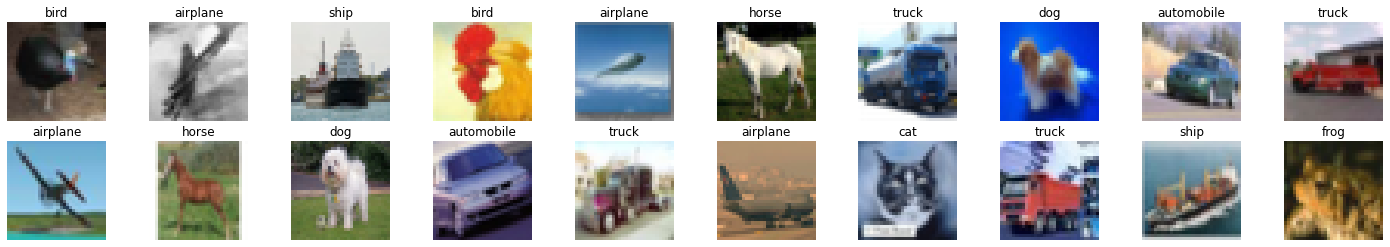

In [11]:
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# display 20 images
# NOTE: make sure your batch size is at least 20
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])

### View an Image in More Detail

Normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

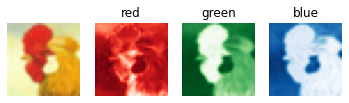

In [12]:
rgb_img = np.squeeze(images[3])
channels = ['composite', 'red', 'green', 'blue']
cmaps = [None, 'Reds', 'Greens', 'Blues']

fig, subs = plt.subplots(1, 4) 

for i, sub in enumerate(subs.flatten()):
    
    if i == 0:
        imshow(rgb_img, sub)
    else:
        img = rgb_img[i-1]
        sub.imshow(img, cmap=cmaps[i])
        sub.set_title(channels[i])
        sub.axis("off")

---
## CNN Architecture

- Two Convolutional Layers with attached MaxPooling layers
- Linear MLP + Dropout layers for the classification

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Duplicate CNN architecture without nn.Sequenctial for better understanding
# class Net(nn.Module):
#     def __init__(self, n_classes=10):

#         super(Net, self).__init__()

#         # convolutional layer 1. It sees 3x32x32 image tensor
#         # and produces 16 feature maps 32x32 (i.e., a tensor 16x32x32)
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
#         self.relu1 = nn.ReLU()
#         # 2x2 pooling with stride 2. It sees tensors 16x32x32
#         # and halves their size, i.e., the output will be 16x16x16
#         self.pool1 = nn.MaxPool2d(2, 2)

#         # convolutional layer (sees the output of the prev layer, i.e.,
#         # 16x16x16 tensor)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # -> 32x16x16
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(2, 2)  # -> 32x8x8

#         # convolutional layer
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # -> 64x8x8
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(2, 2)  # -> 64x4x4

#         # linear layer (64 * 4 * 4 -> 500)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * 4 * 4, 500)
#         self.dp1 = nn.Dropout(0.5)
#         self.rl1 = nn.ReLU()

#         # linear layer (500 -> 10)
#         self.fc2 = nn.Linear(500, n_classes)

#     def forward(self, x):

#         x = self.relu1(self.pool1(self.conv1(x)))
#         x = self.relu2(self.pool2(self.conv2(x)))
#         x = self.relu3(self.pool3(self.conv3(x)))

#         x = self.flatten(x)

#         x = self.rl1(self.dp1(self.fc1(x)))

#         x = self.fc2(x)

#         return x


# We will use nn.Sequential, which makes things a lot easier
class CNN_Net(nn.Module):
    def __init__(self, n_classes=10):

        super(CNN_Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),  # -> 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x8x8
            nn.Conv2d(32, 64, 3, padding=1),  # -> 64x8x8
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x4x4
            nn.Flatten(),  # -> 1x64x4x4
            nn.Linear(64 * 4 * 4, 500),  # -> 500
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):

        return self.model(x)


# create a complete CNN
cnn_model = CNN_Net()
print(cnn_model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    cnn_model.cuda()

CNN_Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [16]:
### Loss Function and Optimizer

import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01)

---
## Train the Network
- Code crashed in my laptop with insufficient memory error
- One epoch ran for 40mins on cloud jupyterserver without GPU
- One epoch ran for 3 mins on cloud jupyterserver with GPU


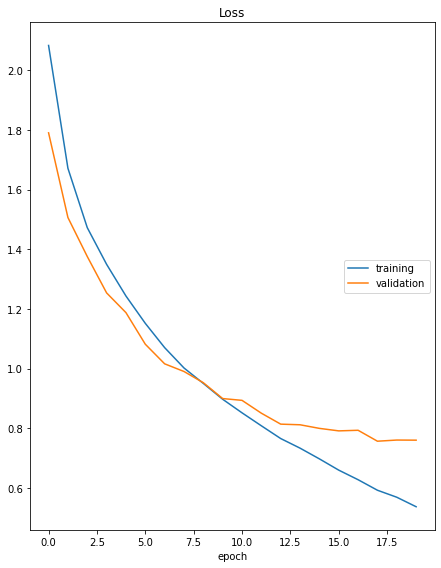

Loss
	training         	 (min:    0.537, max:    2.083, cur:    0.537)
	validation       	 (min:    0.756, max:    1.790, cur:    0.760)


In [17]:
train_model(
    data_loaders,
    cnn_model,
    optimizer,
    loss,
    20,
    "cifar10_model.pt",
    interactive_tracking=True
)

In [19]:
###  Load the Model with the Lowest Validation Loss

cnn_model.load_state_dict(torch.load('cifar10_model.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [20]:
test_loss, preds, actuals = one_epoch_test(data_loaders['valid'], cnn_model, loss)

Testing: 100%|████████████████████████████████| 500/500 [00:16<00:00, 30.70it/s]

Test Loss: 0.756461


Test Accuracy: 73% (7394/10000)


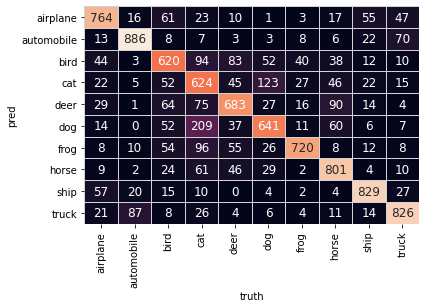

In [23]:
cm = plot_confusion_matrix(preds, actuals, classes)

In [24]:
print("Accuracy by class:\n")
for i, col in enumerate(cm):
    print(f"    {col:11s}: {cm[col][i] / cm[col].sum():.2f}")

Accuracy by class:

    airplane   : 0.78
    automobile : 0.86
    bird       : 0.65
    cat        : 0.51
    deer       : 0.71
    dog        : 0.70
    frog       : 0.86
    horse      : 0.74
    ship       : 0.84
    truck      : 0.81


### Visualize Sample Test Results

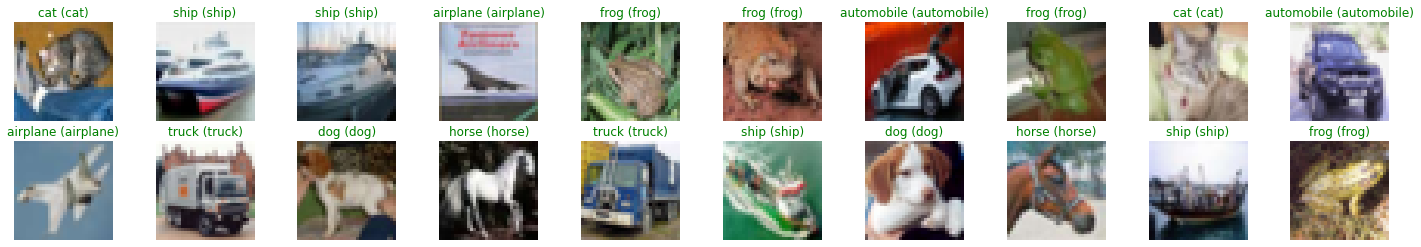

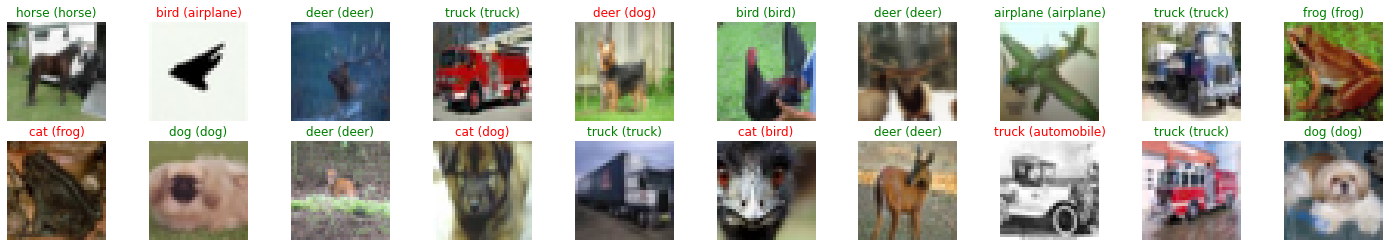

In [25]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])

for i in range(2):
    images, labels = next(dataiter)
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = cnn_model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig, subs = plt.subplots(2, 10, figsize=(25, 4))
    for i, ax in enumerate(subs.flatten()):
        imshow(images[i].cpu().numpy(), ax)
        ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                     color=("green" if preds[i]==labels[i].item() else "red"))
        ax.axis("off")